# Finite Difference Method for the Heat Equation on the Unit Interval

## Import Packages

In [5]:
using LinearAlgebra
using DifferentialEquations
using SparseArrays
using BenchmarkTools 
using Plots 

##  Section 1: Introduction 

Here we study the heat equation in one spatial dimension. 

<b>Problem to solve</b> Let $x \in \Omega=(0,1)$ denote the spatial domain. Let $t \in [0,T]$ denote the time interval. Let $f(x,t)$ denote the forcing term. Let $D$ denote the diffusion coefficient. The partial differential equation for $u(x,t)$ we intend to solve can be written as 

$$
\frac{\partial u}{\partial t} = D \frac{\partial^2 \, u}{\partial x^2} + f(x,t) 
$$ 

(observe the plus sign in front of the Laplacian term in the righ-hand side). 
Linear and non-linear $u$-dependent forcing terms will be added  possibly later. We supply homogeneous boundary conditions for $u(x,t)$, i.e., we impose that 

$$
u(0,t) = 0 \text{ and } u(1,t) = 0 \, . 
$$

We impose non-zero initial conditions for $u(x,t)$, i.e., we impose that

$$
u(x,0) = u_0(x) \text{ and } \dot{u}(x,0) = 0 \, . 
$$

A <b>reference solution</b> can be computed using seperation of variables (implemented symbolically, using e.g. the function [pde_separate](https://docs.sympy.org/latest/modules/solvers/pde.html) in the sympy package) or using the method of manufactured solutions.

For the <b>spatial discretization</b>, we use the central finite difference method on an uniform mesh with $N+1$ nodes (including both boundary nodes). After spatial discretization, the following system of second order ordinary differential equations is obtained 

$$
\dot{\mathbf{u}}(t) = \mathbf{F}(\mathbf{u}, \mathbf{x}, t) \in {\mathbb R}^{N+1}
$$ 

where $\mathbf{F}(\mathbf{u},t)$ contains both linear and non-linear terms. This systems is supplied with initial conditions for $\mathbf{u}(t=0)$. 

##  Section 2: Analytical Reference Solutions 

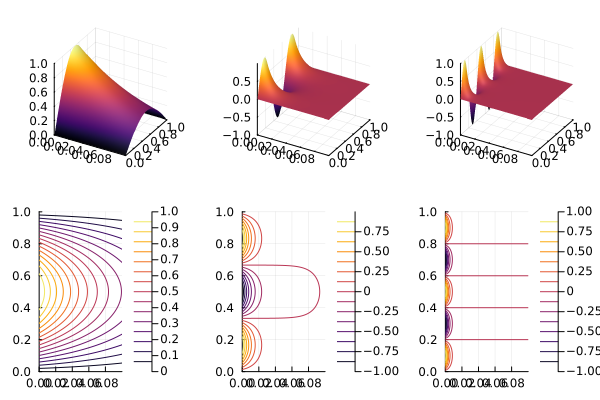

In [63]:
# define analytical reference solution 
function u_anal(x,t,p)
    mode = p 
    return sin(mode*pi*x)*exp(-mode^2*pi^2*t)
end 

# define space-time grid 
N = 100; h = 1/N 
xr = range(0,1,step=h)
Tend = 0.1; dt = Tend/100 
tr = range(0,Tend,step=dt)

# evaluate analytical solution on space-time grid for various parameter values 
mode = 1; p = mode; U1 = u_anal.(xr,tr',Ref(p))
mode = 3; p = mode; U2 = u_anal.(xr,tr',Ref(p))
mode = 5; p = mode; U3 = u_anal.(xr,tr',Ref(p))

# plot reference solutions 
p1 = surface(tr,xr,U1,colorbar=false)
p2 = surface(tr,xr,U2,colorbar=false)
p3 = surface(tr,xr,U3,colorbar=false)
p4 = contour(tr,xr,U1)
p5 = contour(tr,xr,U2)
p6 = contour(tr,xr,U3)
plot(p1,p2,p3,p4,p5,p6,layout = (2,3))

## Section 3: Spatial Discretization: Construct the One-Dimensional Matrix and Vector 

In [62]:
# struct to hold entire mesh
struct Mesh
  #..number of nodes of the mesh..   
  nnodes::Int64
  #..number of elements of the mesh..
  nelements::Int64 
  #..vector of x-coordinates of nodes of the mesh..
  Nodes::Vector{Float64}
end 

# function to generate a mesh on the interval 0 <= x <= 1.   
# we limit the type of input to be Int64 
function genMesh(nelements::Int64)::Mesh
    h = 1/nelements 
    nnodes = nelements+1
    Nodes = Vector{Float64}(0:h:1)    
    mesh = Mesh(nnodes,nelements,Nodes)     
    return mesh;
end 

# generate global stiffness matrix 
function genStiffMat(mesh::Mesh)

    #..recover number of elements and nodes  
    nelements = mesh.nelements
    nnodes    = nelements+1
    
    #..set mesh width and square of mesh width 
    h = 1/nelements; h2=h*h; 

    #..construct the coefficient matrix with our the boundary conditions 
    e = ones(nnodes); 
    A = Tridiagonal(-e[2:end], 2*e, -e[2:end]); 
    A = (1/h2)*A;     
   
    return A; 
    
end

function genVector(mesh, sourceFct::F) where F 

    #..recover mesh nodes  
    nodes = mesh.Nodes
    
    #..set vector values using broadcasting (dot syntax)  
    f = sourceFct.(nodes)
   
    return f; 
end

function genBoundaries!(mesh,A,f)
    
    #..recover number of elements and nodes  
    nelements = mesh.nelements
    nnodes = mesh.nnodes 
    
    #..set mesh width and square of mesh width 
    h = 1/nelements; h2=h*h; 
    
    #..set homogeneous Dirichlet boundary conditions at both end points  
    if (true)
        display(" Setting homogeneous Dirichet conditions on both sides")
        A[1,1] = 0.; A[1,2] = 0.; f[1] = 0. 
        A[end,end] = 0.; A[end,end-1] = 0.; f[end] = 0.
    elseif (false)
        #..set homogeneous Dirichlet left and homogeneous Neumann right
        display(" Setting homogeneous Neumann conditions on the right hand side:: Option-1")
        A[1,1] = 1.;        A[1,2] = 0.;         
        A[end,end] = 1/h ;  A[end,end-1] = -1/h;      
    elseif (false)
        #..set homogeneous Dirichlet left and homogeneous Neumann right
        display(" Setting homogeneous Neumann conditions on the right hand side:: Option-2")
        A[1,1] = 1.;        A[1,2] = 0.;         
        A[end,end] = 1/h ;  A[end,end-1] = -1/h;       
    elseif (false)
        display(" Setting periodic boundary conditions:: Option-1")
        A = sparse(A)
        A[1,end-1] = -1/h2; 
        A[end,2]   = -1/h2;
    elseif (false)
        display(" Setting periodic boundary conditions:: Option-2")
        A = sparse(A)
        A[1,end-1] = -1/h2; 
        [A[end,i] = -1. for i =1:nnodes];        
    else 
        error(" genSolution::Error::Boundary conditions not set")
    end 
    return A,f   
end

genBoundaries! (generic function with 1 method)

## Section 4: Time-Integration Using DifferentialEquations.jl 

" Setting homogeneous Dirichet conditions on both sides"

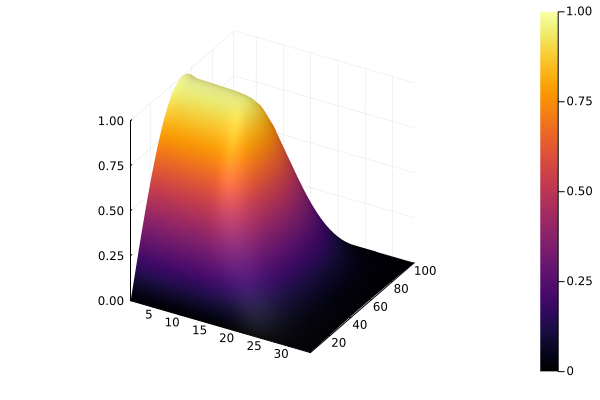

In [96]:
#..discretize in space.. 
nelements = 100; mesh = genMesh(nelements); 
fsource(x) = 0
A = genStiffMat(mesh); f = genVector(mesh,fsource) 
A,f = genBoundaries!(mesh,A,f); 
A = -A;

#..set rhs function that defines the ODE.. 
function rhs!(du, u,p,t)
    A, f = p 
    du .= A*u   
end
                                    
#..set time begin and end forward.. 
t0 = 0.0
tf = 0.5 
tspan = (t0,tf)

#..set initial conditions.. 
mode= 1; p_anal = mode
u0 = u_anal.(mesh.Nodes,0,p_anal)

#..define ODE problem to be solved..  
p = [A,f] 
prob = ODEProblem(rhs!, u0, tspan, p)

#..solve ODE problem using time integration..  
sol = DifferentialEquations.solve(prob,AutoVern7(Rodas5()), reltol = 1e-6, abstol = 1e-6, save_everystep = true)

#..retrieve and plot solution 
U  = sol[1:nelements+1,:]
surface(U)

## References